<img src="image.png">

In [9]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

In [10]:
R1 = 0.8
R2 = 0.3
EV = 0.8
N = 50
box_x = np.array([0, 0, 1, 1, 0])
box_y = np.array([0, 1, 1, 0, 0])

box = np.zeros((N*(len(box_x)-1),4))
t = 0

for i in range(len(box_x)-1):
    for i1,j,k,l in zip(np.linspace(box_x[i], box_x[i+1], N+1)[:-1], 
                   np.linspace(box_y[i], box_y[i+1], N+1)[:-1],
                   np.linspace(box_x[i], box_x[i+1], N+1)[1:], 
                   np.linspace(box_y[i], box_y[i+1], N+1)[1:]):
        box[t] = np.array([i1,j,k,l])
        t = t + 1
        
obj = box*0.1 + [0.7, 0.3, 0.7, 0.3]
lines = np.concatenate([box, obj])#массив отрезков в формате x1, y1, x2, y2

In [11]:
def E_f(t):
    r = []
    for x in t:
        if 0.3<=x[1]<=0.6 and x[0] == 0.0:
            r.append(EV)
        else:
            r.append(0.0)
    return r

def calc_angle(v1, v2):
    det = v1[0]*v2[1] - v2[0]*v1[1]
    return np.arctan2(det, np.dot(v1,v2))

def check_visibility(l1, l2):
    q = np.array([(l1[2]+l1[0]), (l1[3]+l1[1])])/2.0 #середины отрезков
    q1 = np.array([(l2[2]+l2[0]), (l2[3]+l2[1])])/2.0
    k = 0
    
    if q1[0] != q[0]:
        k = (q1[1]-q[1])/(q1[0]-q[0])
        b = -k * q1[0] + q1[1]
    else:
        return 0.7<q1[0]<0.8
    
    if k!=0:
        points = []
        
        #точки пересечения прямой  соединяющей центры с объектами сцены
        if 0<=(1-b)/k<=1:
            points.append(np.array([(1-b)/k,1]))
            
        if 0<=-b/k<=1:
            points.append(np.array([-b/k,0]))
             
        if 0<=b<=1:
            points.append(np.array([0,b]))
             
        if 0<=k+b<=1:
            points.append(np.array([1,k+b]))
            
        if 0.7<=(0.3-b)/k<=0.8:
            points.append(np.array([(0.3-b)/k, 0.3]))
                   
        if 0.7<=(0.4-b)/k<=0.8:
            points.append(np.array([(0.4-b)/k, 0.4]))
                           
        if 0.3<=0.7*k+b<=0.4:
            points.append(np.array([0.7, 0.7*k+b]))
                      
        if 0.3<=0.8*k+b<=0.4:
            points.append(np.array([0.8, 0.8*k+b]))
            
        points = sorted(points,key=itemgetter(0,1))
        
        for i in range(len(points)-1): #проверка того что прямая не точек пересечения на отрезке между центрами
            if (abs(points[i] - q)<1e-10).all() and (abs(points[i+1] - q1)<1e-10).all()\
                or (abs(points[i] - q1)<1e-10).all() and (abs(points[i+1] - q)<1e-10).all():
                return True
        return (points[-1] == q).all() and (points[-2] == q1).all()
    else:
        return 0.3<q1[1]<0.4

In [12]:
R = np.array([R1]*N + [0]*N + [0]*N + [R1]*N + [R2]*N + [0]*N + [0]*N + [R2]*N) 
E = np.array(E_f(lines))

<IPython.core.display.Javascript object>


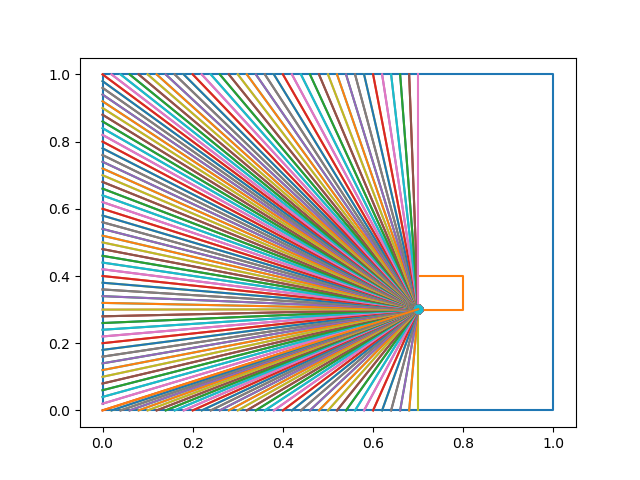

Wall time: 8.17 s


In [13]:
%%time
plt.figure()
plt.plot(box[:,2], box[:,3])
plt.plot(obj[:,2], obj[:,3])
F = np.zeros((len(lines),len(lines))) #матрица форм-фактора
for i,l1 in enumerate(lines):
    for j,l2 in enumerate(lines):
        #отсекаются ненужные проверки точек на одной линии, и тех что находятся на внутреннем объекте
        if i//N != j//N and not (4*N<=i<=8*N and 4*N<=j<=8*N) and check_visibility(l1,l2):
            q = np.array([(l1[2]+l1[0]), (l1[3]+l1[1])])/2.0
            if i == 200:
                q1 = np.array([(l2[2]+l2[0]), (l2[3]+l2[1])])/2.0
                plt.plot(q[0],q[1],'o')
                if check_visibility(l1,l2):
                    plt.plot([q[0],l2[0]], [q[1],l2[1]])
                    plt.plot([q[0],l2[2]], [q[1],l2[3]])
            gamma_1 = calc_angle(l1[0:2]-q, l2[0:2]-q)
            gamma_2 =  calc_angle(l1[0:2]-q, l2[2:4]-q)
            F[i][j] = abs(gamma_1-gamma_2)/np.pi
        else:
            F[i][j] = 0

### добавлена нормировка F

In [14]:
F = F/F.sum(axis=1)[:,np.newaxis] 

In [15]:
S = np.linalg.solve((np.eye(lines.shape[0])-F*R), E)

<IPython.core.display.Javascript object>


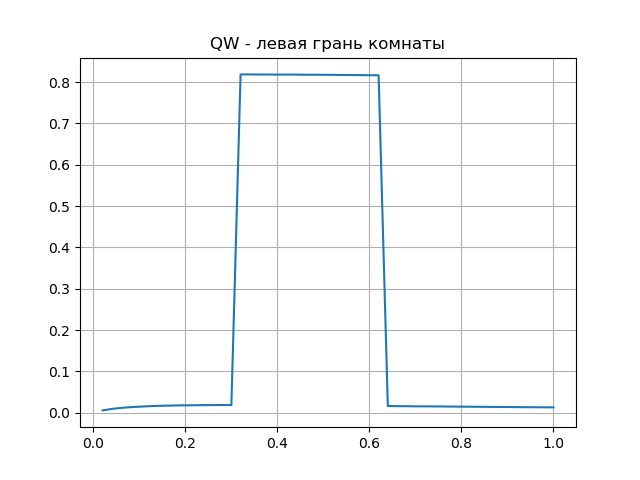

<IPython.core.display.Javascript object>


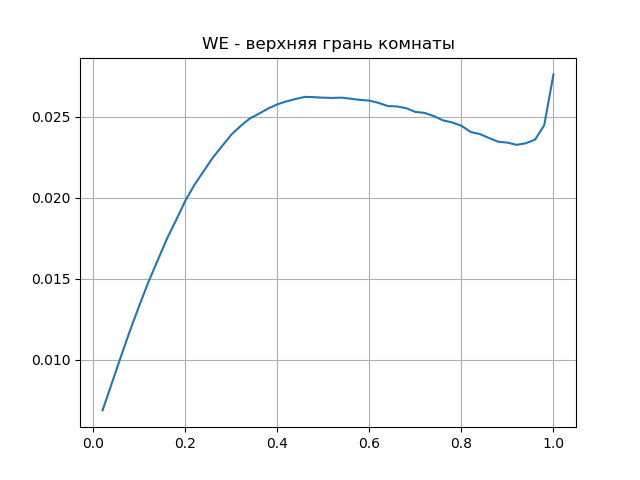

<IPython.core.display.Javascript object>


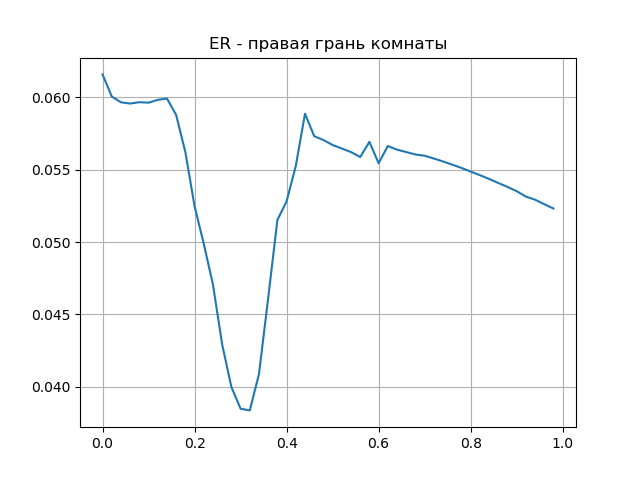

<IPython.core.display.Javascript object>


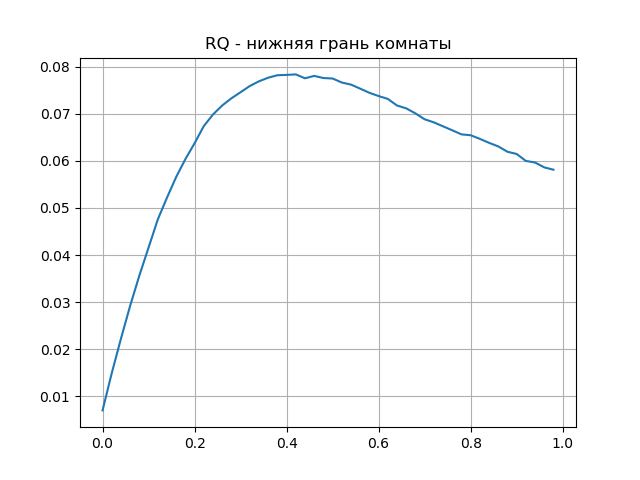

<IPython.core.display.Javascript object>


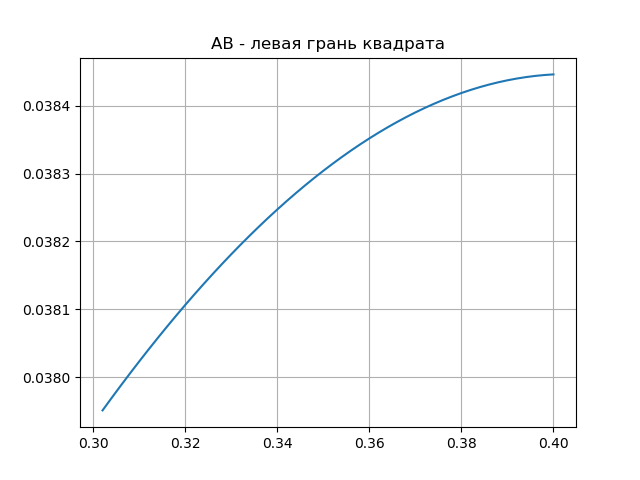

<IPython.core.display.Javascript object>


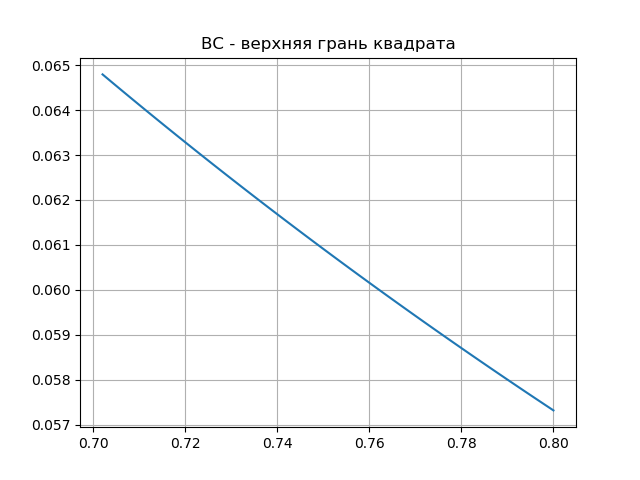

<IPython.core.display.Javascript object>


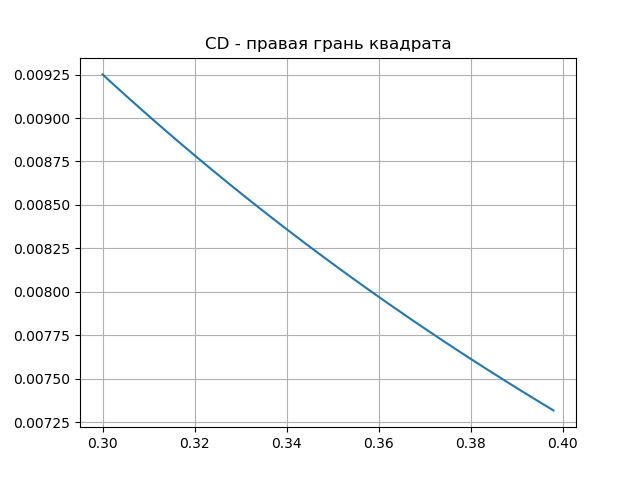

<IPython.core.display.Javascript object>


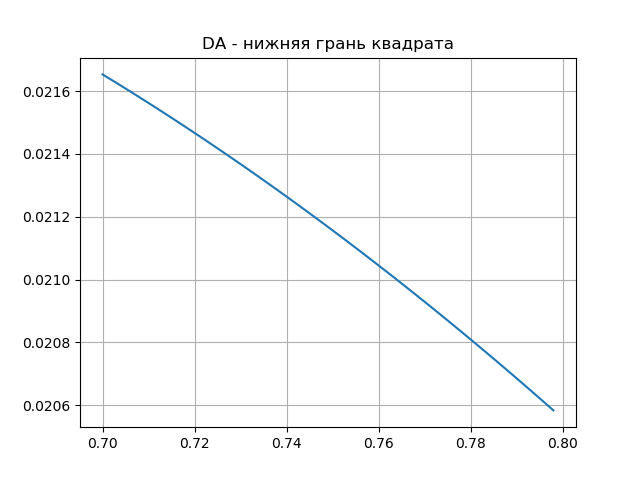

In [16]:
names = ['QW - левая грань комнаты', 
         'WE - верхняя грань комнаты', 
         'ER - правая грань комнаты', 
         'RQ - нижняя грань комнаты',
         'AB - левая грань квадрата', 
         'BC - верхняя грань квадрата',
         'CD - правая грань квадрата', 
         'DA - нижняя грань квадрата',]
for i in range(8):
    plt.figure()
    plt.grid()
    plt.title(names[i])
    if lines[i*N:i*N+N,2][0] != lines[i*N:i*N+N,2][1]:
        plt.plot(lines[i*N:i*N+N,2], S[i*N:i*N+N])
    else:
        plt.plot(lines[i*N:i*N+N,3], S[i*N:i*N+N])

In [17]:
display(F)

array([[0.        , 0.        , 0.        , ..., 0.00031648, 0.00031802,
        0.00031957],
       [0.        , 0.        , 0.        , ..., 0.00030235, 0.00030386,
        0.00030537],
       [0.        , 0.        , 0.        , ..., 0.00028538, 0.00028682,
        0.00028828],
       ...,
       [0.00258994, 0.00264082, 0.0026899 , ..., 0.        , 0.        ,
        0.        ],
       [0.00259521, 0.00264645, 0.00269588, ..., 0.        , 0.        ,
        0.        ],
       [0.0026005 , 0.0026521 , 0.00270189, ..., 0.        , 0.        ,
        0.        ]])